# Step 1. Data explore

This the first step

1. [**Data exploration**](#)
2. 

In [1]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

csv_path='data/GBPUSD_Candlestick_1_M_ASK_01.02.2018-01.02.2019.csv'

In [2]:
# prepare date parser
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y %H:%M:%S.%f')
# load csv
df = pd.read_csv(csv_path,
                 header=0,
                 index_col='Gmt time',
                 names=['Gmt time', 'Open', 'High', 'Low', 'Close', 'Volume'],
                 parse_dates=['Gmt time'],
                 date_parser=dateparse)
df.columns = ['open', 'high', 'low', 'close', 'volume']
df.index.rename('time', inplace=True)
print('Row count = %d' % len(df))
df.head(5)

Row count = 527040


,open,high,low,close,volume
time,,,,,
2018-02-01 00:00:00,1.41996,1.42005,1.41994,1.42005,81.63
2018-02-01 00:01:00,1.42008,1.42014,1.41993,1.41997,130.89
2018-02-01 00:02:00,1.41996,1.42030,1.41996,1.42020,109.85
2018-02-01 00:03:00,1.42020,1.42060,1.42020,1.42043,213.38
2018-02-01 00:04:00,1.42043,1.42048,1.42043,1.42045,133.74


In [3]:
# inspect nan value
df.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

# Clean invalid row

In [4]:
# remove invalid candle
invalid_index = df[(df['high'] == df['low']) & (df['high'] == df['open']) &
                   (df['open'] == df['close']) & (df['volume'] == 0)].index
print('Invalid row count = %s'% len(invalid_index))

df = df.drop(invalid_index)
print('Row count = %d' % len(df))

Invalid row count = 152444
Row count = 374596


# Extract basic features

In [5]:
# hour
time = pd.Series(df.index, index=df.index)
hours = time.apply(lambda x: x.hour)
df['hour'] = hours
df.tail()

,open,high,low,close,volume,hour
time,,,,,,
2019-02-01 21:55:00,1.30773,1.30799,1.30773,1.30796,91.58,21
2019-02-01 21:56:00,1.30797,1.30844,1.30796,1.30842,66.66,21
2019-02-01 21:57:00,1.30843,1.30857,1.30835,1.30835,94.78,21
2019-02-01 21:58:00,1.30836,1.30859,1.30790,1.30815,173.23,21
2019-02-01 21:59:00,1.30816,1.30839,1.30803,1.30839,45.15,21


In [6]:
# function to calculate pips
def pip(price=None, _abs=False):
    
    pip_unit = 0.0001
    if price:
        price = float(price)
        if _abs:
            price = abs(price)
        return (price / pip_unit)

    return pip_unit

In [7]:
volatility = df['high'] - df['low']
volatility = volatility.apply(lambda x: pip(x))
volatility
df['volatility'] = volatility
df.tail()

,open,high,low,close,volume,hour,volatility
time,,,,,,,
2019-02-01 21:55:00,1.30773,1.30799,1.30773,1.30796,91.58,21,2.6
2019-02-01 21:56:00,1.30797,1.30844,1.30796,1.30842,66.66,21,4.8
2019-02-01 21:57:00,1.30843,1.30857,1.30835,1.30835,94.78,21,2.2
2019-02-01 21:58:00,1.30836,1.30859,1.30790,1.30815,173.23,21,6.9
2019-02-01 21:59:00,1.30816,1.30839,1.30803,1.30839,45.15,21,3.6


In [8]:
df.volatility.describe()

count    374596.000000
mean          2.126742
std           2.015416
min           0.000100
25%           0.900000
50%           1.700000
75%           2.800000
max         107.800000
Name: volatility, dtype: float64

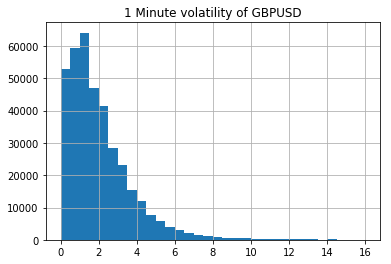

In [9]:
plt.title(r'1 Minute volatility of GBPUSD')
df[df['volatility'] < 16].volatility.hist(bins=32,label='asdfasf')

In [10]:
no_volume_len=len(df[df['volume']==0])
print('Row with no volume = %s, %.2f%%'% (no_volume_len,no_volume_len/len(df)*100))
df.volume.sort_values().tail(10)

Row with no volume = 0, 0.00%


time
2018-09-20 06:36:00      2963.6799
2018-03-12 08:59:00      3862.5300
2018-08-08 07:07:00      4171.7700
2018-02-19 00:38:00      4773.6099
2018-10-29 07:30:00      7268.8999
2018-03-09 14:29:00     10337.9102
2018-04-04 15:00:00     10537.0303
2018-08-08 07:08:00     11699.4902
2018-06-27 11:49:00     17872.5703
2018-05-04 12:22:00    109507.7813
Name: volume, dtype: float64

In [12]:
# Calculate first and third quartile
first_quartile = df['volume'].describe()['25%']
third_quartile = df['volume'].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
dfv = df[(df['volume'] > 0) &
            (df['volume'] < (third_quartile + 3 * iqr))]

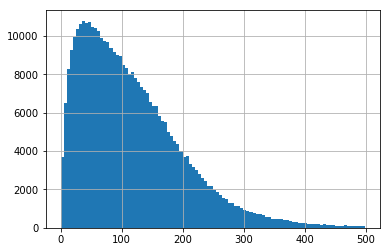

In [13]:
# drop that outlier and draw hist
dfv.volume.hist(bins=100)

# Hourly analysis


In [14]:
index = []
volume_data = []
volatility_data = []

for i in range(24):
    volume_desc = df[(df.hour == i)].volume.describe()
    volatility_desc = df[(df.hour == i)].volatility.describe()
    volume_sum=df[(df.hour == i)].volatility.sum()
    
    volume_data.append((i,volume_desc['mean'], volume_desc['std'], volume_desc['min'], volume_desc['25%'], volume_desc['50%'], volume_desc['75%'], volume_desc['max'],volume_sum))
    volatility_data.append((i,volatility_desc['mean'], volatility_desc['std'], volatility_desc['min'], volatility_desc['25%'], volatility_desc['50%'], volatility_desc['75%'], volatility_desc['max']))
volume_df = pd.DataFrame(volume_data, columns=['hour','mean', 'std', 'min', '25%', '50%', '75%', 'max','sum'])
volume_df = volume_df.set_index('hour')
volatility_df = pd.DataFrame(volatility_data, columns=['hour','mean', 'std', 'min', '25%', '50%', '75%', 'max'])
volatility_df = volatility_df.set_index('hour')

In [15]:
volume_df.head(3)

,mean,std,min,25%,50%,75%,max,sum
hour,,,,,,,,
0,71.745222,65.752865,1.00,36.975,60.365,92.9475,4773.6099,21344.4085
1,83.044718,53.000800,0.95,45.420,72.530,108.3000,676.7700,21891.0067
2,73.167458,51.394436,1.00,37.895,61.900,95.2150,1039.8500,18535.2132


Text(0.5, 1.0, 'GBPUSD Hourly volume')

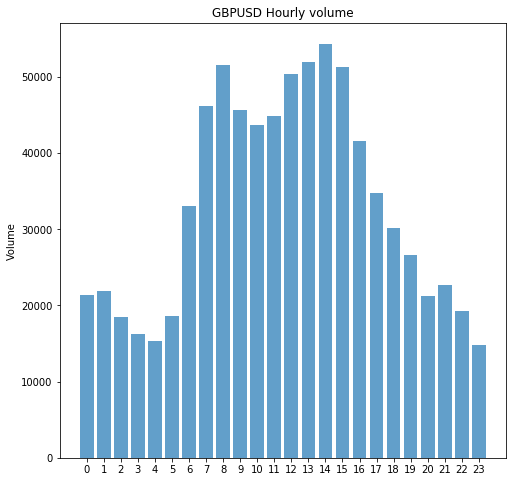

In [16]:
# Hourly volume
figsize(8, 8)

plt.bar(volume_df.index, volume_df['sum'], align='center', alpha=0.7)
plt.ylabel('Volume')
plt.xticks(volume_df.index, range(24))
plt.title('GBPUSD Hourly volume')

Text(0.5, 1.0, 'GBPUSD Hourly Volatility')

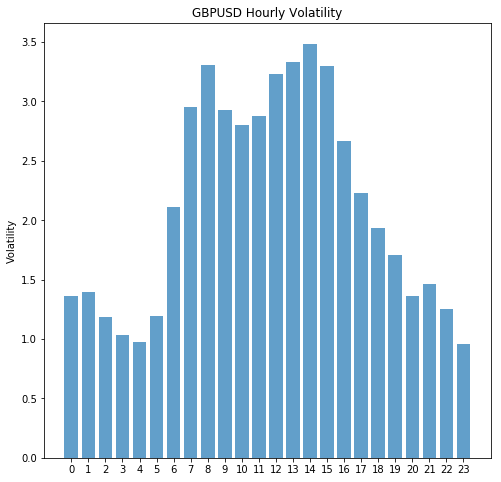

In [17]:
# Hourly volatility
figsize(8, 8)

plt.bar(volatility_df.index, volatility_df['mean'], align='center', alpha=0.7)
plt.ylabel('Volatility')
plt.xticks(volatility_df.index, range(24))
plt.title('GBPUSD Hourly Volatility')

# Save data for next step

In [23]:
df.to_csv('data/GBPUSD_Candlestick_1_M_ASK_01.02.2018-01.02.2019_cleaned.csv', float_format='%.5f')

# Clean data for test dataset

In [26]:
test_df = pd.read_csv(
    'data/GBPUSD_Candlestick_1_M_ASK_01.02.2019-24.04.2019.csv',
    header=0,
    index_col='Gmt time',
    names=['Gmt time', 'Open', 'High', 'Low', 'Close', 'Volume'],
    parse_dates=['Gmt time'],
    date_parser=dateparse)
test_df.columns = ['open', 'high', 'low', 'close', 'volume']
test_df.index.rename('time', inplace=True)
print('Row count = %d' % len(test_df))

Row count = 118080


In [28]:
# remove invalid candle
invalid_index = test_df[(test_df['high'] == test_df['low']) & (test_df['high'] == test_df['open']) &
                   (test_df['open'] == test_df['close']) & (test_df['volume'] == 0)].index
print('Invalid row count = %s'% len(invalid_index))

test_df = test_df.drop(invalid_index)
print('Row count = %d' % len(test_df))

Invalid row count = 34557
Row count = 83523


In [29]:
test_df.to_csv('data/GBPUSD_Candlestick_1_M_ASK_01.02.2019-24.04.2019_cleaned.csv', float_format='%.5f')
